In [6]:
import os
import numpy as np
from phathom import io
from phathom.preprocess import filtering
from phathom.phenotype import celltype
from phathom import plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
%matplotlib notebook

In [8]:
working_dir = '/media/jswaney/ssd/organoid_phenotyping/20181206_eF9_A34_1/'

# Smooth the cell-type markers

In [9]:
zarr_paths = [
              'sox2.zarr/1_1_1',
              'tbr1.zarr/1_1_1'
             ]
smooth_zarr_paths = [
                     'sox2_smooth.zarr',
                     'tbr1_smooth.zarr'
                    ]
sigma = (1.2, 2.5, 2.5)
chunks = (128, 128, 128)
overlap = 8
nb_workers = 4

In [11]:
arrs = [io.zarr.open(os.path.join(working_dir, path)) 
        for path in zarr_paths]

In [ ]:
smooth_arrs = []
for smooth_zarr_path in smooth_zarr_paths:
    smooth_zarr = io.zarr.new_zarr_like(os.path.join(working_dir, 
                                                     smooth_zarr_path), 
                                        arr)
    smooth_arrs.append(smooth_zarr)

In [10]:
for i, o in zip(arrs, smooth_arrs):
    filtering.gaussian_blur_parallel(i, 
                                     sigma, 
                                     o, 
                                     chunks, 
                                     overlap, 
                                     nb_workers)

100%|██████████| 2166/2166 [01:07<00:00, 32.29it/s] 


# Sample signals at cell centers

In [12]:
centers_path = 'centers.npy'

centers = np.load(os.path.join(working_dir, centers_path))
centers.shape

(2421822, 3)

In [110]:
radius = 1

mfi = np.zeros((centers.shape[0], len(smooth_zarr_paths)))
stdev = np.zeros((centers.shape[0], len(smooth_zarr_paths)))

for i, path in enumerate(smooth_zarr_paths):
    arr = io.zarr.open(os.path.join(working_dir, path))
    intensities = celltype.nuclei_centered_intensities(arr, 
                                                       centers, 
                                                       radius)
    mfi[:, i] = celltype.calculate_mfi(intensities)
    stdev[:, i] = celltype.calculate_stdev(intensities)

100%|██████████| 2421822/2421822 [06:24<00:00, 6304.57it/s]


<IPython.core.display.Javascript object>


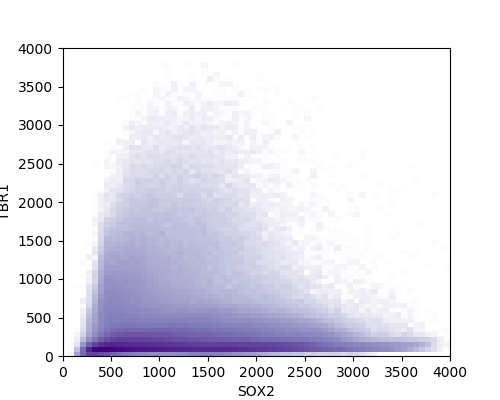

In [111]:
# plotting.plot_hist_2d(mfi[:, 0], mfi[:, 1], bins=128, _range=((200, 1600), (0, 1000)))
plt.figure(figsize=(5, 4))
plt.hist2d(mfi[:, 0], mfi[:, 1], 
           bins=64, 
           range=((0, 4000), (0, 4000)), 
           cmin=0, 
           cmax=200000, 
           cmap='Purples',
           norm=mpl.colors.LogNorm())
plt.xlabel('SOX2')
plt.ylabel('TBR1')
plt.show()

In [17]:
sox2_threshold = 1500
tbr1_threshold = 500

sox2_idx = np.where(mfi[:, 0] > sox2_threshold)[0]
tbr1_idx = np.where(mfi[:, 1] > tbr1_threshold)[0]

<IPython.core.display.Javascript object>


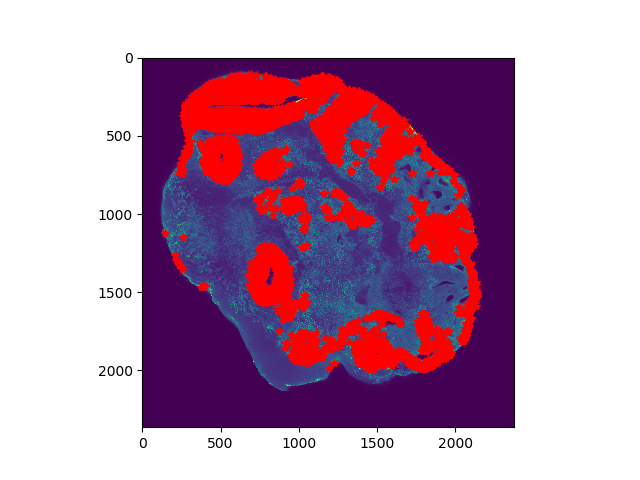

In [20]:
plotting.zprojection(arrs[0], centers[sox2_idx], zlim=[200, 204])

<IPython.core.display.Javascript object>


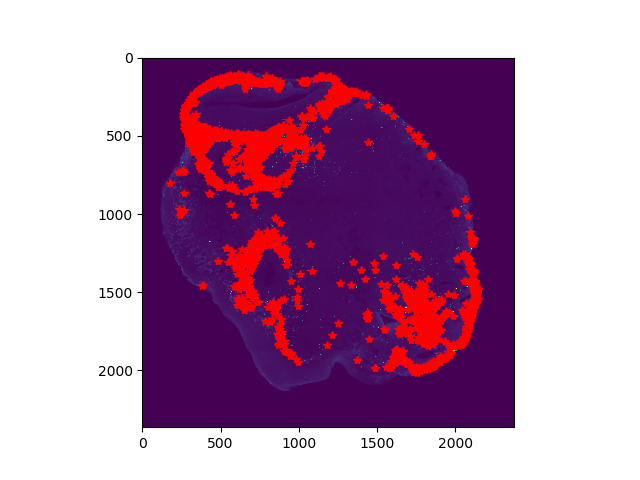

In [21]:
plotting.zprojection(arrs[1], centers[tbr1_idx], zlim=[200, 208])

In [115]:
sox2_labels = celltype.threshold_mfi(mfi[:, 0], sox2_threshold)
tbr1_labels = celltype.threshold_mfi(mfi[:, 1], tbr1_threshold)

# Save the results

In [116]:
sox2_path = 'sox2_labels.npy'
tbr1_path = 'tbr1_labels.npy'

np.save(os.path.join(working_dir, sox2_path), sox2_labels)
np.save(os.path.join(working_dir, tbr1_path), tbr1_labels)

# Load previous labels

In [14]:
sox2_path = 'sox2_labels.npy'
tbr1_path = 'tbr1_labels.npy'

sox2_labels = np.load(os.path.join(working_dir, sox2_path))
tbr1_labels = np.load(os.path.join(working_dir, tbr1_path))

In [16]:
mfi = np.load(os.path.join(working_dir, 'single_cell_mfi.npy'))